In [105]:
!pip install spacy

In [ ]:
!wget "https://raw.githubusercontent.com/CrissRMFI/TA047R-2C2024-GRUPO08/refs/heads/main/TP2/test.csv";
!wget "https://raw.githubusercontent.com/CrissRMFI/TA047R-2C2024-GRUPO08/refs/heads/main/TP2/train.csv";

In [106]:
import pandas as pd
import nltk
from nltk import sent_tokenize
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [107]:
sns.set(style="whitegrid")

In [108]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [109]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [110]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Pre - Procesamiento

### Separo los datos en variables de entrada y etiquetas

In [111]:
X_train_title = train_set['title']
X_train_description = train_set['description']
X_train_project = train_set['project']
Y_train_point = train_set['storypoint']

In [112]:
label_encoder = LabelEncoder()
train_set['project-encoder'] = label_encoder.fit_transform(train_set['project']).reshape(-1, 1)
test_set['project-encoder'] = label_encoder.transform(test_set['project']).reshape(-1, 1)

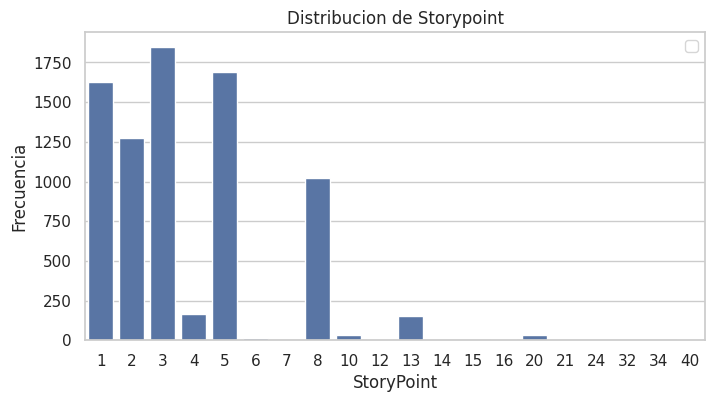

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=train_set,x='storypoint')
plt.xlabel('StoryPoint')
plt.ylabel('Frecuencia')
plt.title('Distribucion de Storypoint')
plt.legend()
plt.show()

### Mostramos un sample de algunas descripciones, titulos y storypoint

In [114]:
sample_train = train_set.sample(n=10)

for _, row in sample_train.iterrows():
    print("\033[1m"+"Título:\n"+"\033[0m", row["title"])
    print("\033[1m"+"Descripción:\n"+"\033[0m", row["description"])
    print("\033[1m"+ "Storypoint: " , row["storypoint"] )
    print("\n" + "-"*30 + "\n")


Título:
 Slave should wait() and start executor registration timeout after launch 
Descripción:
 The current code will start launch a container and wait on it before the launch is complete. We should do this only after the container has successfully launched. Likewise for the executor registration timeout.
Storypoint:  3

------------------------------

Título:
 Fail producer job if required chain artifacts do not get produced
Descripción:
  https://extranet.atlassian.com/display/BAMBOO/Copy+in+place+artifact+subscriptions
Storypoint:  2

------------------------------

Título:
 Consolidate authorization actions for quota.
Descripción:
 We should have just a single authz action: {{UPDATE_QUOTA_WITH_ROLE}}. It was a mistake in retrospect to introduce multiple actions.    Actions that are not symmetrical are register/teardown and dynamic reservations. The way they are implemented in this way is because entities that do one action differ from entities that do the other. For example, regis

### Eliminamos nombres de rutas y librerias

In [115]:
import re

def clean_description(description):
    # Eliminar rutas de archivos y librerías
    description = re.sub(r'(/[\w./-]+)|([a-zA-Z]:\\[\w.\\-]+)', ' ', description)
    # Eliminar URLs
    description = re.sub(r'http[s]?://\S+', ' ', description)
    # Eliminar líneas de código (sencillas)
    description = re.sub(r'^\s*\$.*$', ' ', description, flags=re.MULTILINE)
    description = re.sub(r'^\s*#.*$', ' ', description, flags=re.MULTILINE)
    description = re.sub(r'`[^`]+`', ' ', description)
    # Eliminar caracteres especiales
    description = re.sub(r'[^a-zA-Z0-9\s]', ' ', description)  # Mantener solo letras, números y espacios
    # Opcional: Eliminar múltiples espacios en blanco
    description = re.sub(r'\s+', ' ', description).strip()  # Reemplazar múltiples espacios con uno solo y eliminar espacios al inicio y fin
    return description


In [116]:
train_set['description'] = train_set['description'].map(lambda x: clean_description(x))
train_set['title'] = train_set['title'].map(lambda x: clean_description(x))

test_set['description'] = test_set['description'].map(lambda x: clean_description(x))
test_set['title'] = test_set['title'].map(lambda x: clean_description(x))

## Tokenizamaos por palabras

## Tokenizacion - NLTK - Stop Words

In [117]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [118]:
def tokenize_and_remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

In [119]:
model_word_tokenize = train_set.copy(deep=True)
tokens_title = model_word_tokenize['title'].map(lambda x: tokenize_and_remove_stopwords(x))
tokens_description = model_word_tokenize['description'].map(lambda x: tokenize_and_remove_stopwords(x))
mean_len_token_title = model_word_tokenize['title'].map(lambda x: np.mean([len(token) for token in tokenize_and_remove_stopwords(x)]))
mean_len_token_description = model_word_tokenize['description'].map(lambda x: np.mean([len(token) for token in tokenize_and_remove_stopwords(x)]))


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Vectorizamos aplicando la técnica de TF-IDF y Bag Of Words

In [120]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
nlp = spacy.load("en_core_web_sm")

In [121]:
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

In [122]:
def procesar(data_set, vectorizer, train=True):
    print(f"train = {train}")
    data_set['title_description_lemmatized'] = (data_set['title'] + ' ' + data_set['description']).apply(lemmatize_text)


    if train:
      func = vectorizer.fit_transform
    else:
      func = vectorizer.transform

    title_description_vec = func(data_set['title_description_lemmatized'])


    project_encoder = data_set['project-encoder'].values.reshape(-1, 1)
    vec = np.hstack((title_description_vec.toarray(), project_encoder))
    # data_set['vectorized'] = list(vec)

    return vec, vectorizer

vectorizer_tfidf = TfidfVectorizer()
vectorizer_bow = CountVectorizer(stop_words='english')

def procesar_tfidf(data_set, *args, **kwargs):
    return procesar(data_set, vectorizer_tfidf, *args, **kwargs)

def procesar_bow(data_set, *args, **kwargs):
    return procesar(data_set, vectorizer_bow, *args, **kwargs)



In [123]:
# train_set, vectorizer = procesar_tfidf(train_set, train=True)
# test_set, _ = procesar_tfidf(test_set, train=False, vectorizer=vectorizer)
# train_set, vectorizer = procesar_bow(train_set, train=True)
# test_set, _ = procesar_bow(test_set, train=False, vectorizer=vectorizer)

In [124]:
def create_result_df(df, predictions):
  # predictions based on data originally from df
  results = pd.DataFrame({
    'id': df['id'],
    'storypoint': predictions
    })
  return results

In [125]:
!pip install textblob

from textblob import TextBlob
def get_sentiment(text):
  blob = TextBlob(text)
  return blob.sentiment.polarity

# modelo

## Naive Bayes (multinomial)

In [126]:
from sklearn.naive_bayes import MultinomialNB

In [127]:
from sklearn.model_selection import  StratifiedKFold, KFold, RandomizedSearchCV

kfold = StratifiedKFold(n_splits=5)

clf = MultinomialNB(force_alpha=True)


params = {
    # 'estimator__objective': ['reg:squarederror'],
    # 'estimator__eval_metric': ['rmse'],
    'alpha' : [0., 0.5, 1.0],
    'fit_prior' : [True, False],

}

rs = RandomizedSearchCV(estimator=clf, param_distributions = params, cv=kfold, n_iter=8, random_state=29834)

In [128]:
X, _ = procesar_tfidf(train_set)
# X, _ = procesar_bow(train_set)
y = Y_train_point

train = True


In [129]:
rs.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=8. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:205: RuntimeWarning: inva

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=MultinomialNB(), n_iter=8,
                   param_distributions={'alpha': [0.0, 0.5, 1.0],
                                        'fit_prior': [True, False]},
                   random_state=29834)

In [130]:
predictions = rs.best_estimator_.predict(X)
predictions_rounded = np.round(predictions).astype(int)

## Metricas

In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

mse = mean_squared_error(Y_train_point, predictions)
rmse = root_mean_squared_error(Y_train_point, predictions)
mae = mean_absolute_error(Y_train_point, predictions)

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

metricas = {
    'metrica' : ["MSE", "RMSE", "MAE"],
    'valor' :  [mse, rmse, mae]
}
df_metrics = pd.DataFrame(metricas)
print(df_metrics)

  metrica     valor
0     MSE  7.877468
1    RMSE  2.806683
2     MAE  1.647848


In [133]:
X_t, _ = procesar_tfidf(test_set, False)
# X_t, _ = procesar_bow(test_set, False)

train = False


In [134]:
predictions = rs.best_estimator_.predict(X_t)
predictions_rounded = np.round(predictions).astype(int)

In [135]:
res = create_result_df(test_set, predictions_rounded)
res.to_csv('results-naivebayes-03.csv', index=False, header=True)

In [136]:
res.head(5)

,id,storypoint
0,3433,5
1,106,1
2,7182,3
3,8985,5
4,2149,1


In [137]:
rs.best_params_

{'fit_prior': True, 'alpha': 0.5}

## Guardar modelo con pickle

In [138]:
import joblib

model_pkl_file = "bayes-naive.joblib"

with open(model_pkl_file, 'wb') as file:
    joblib.dump(rs, file)